<a href="https://colab.research.google.com/github/sravani1102/Final-Year-Project/blob/main/DRDiagonsis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import numpy as np
import cv2 as cv
import random
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, InputLayer, concatenate, Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Reshape, Dropout, Activation, Permute
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model as plot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [4]:
# paths
train_img_dir = 'IDRID_Diagonsis/train'
test_img_dir = 'IDRID_Diagonsis/test'
traindf_path = 'IDRID_Diagonsis/training_labels.xlsx'
testdf_path = 'IDRID_Diagonsis/testing_labels.xlsx'

In [5]:
# CSV to Pandas Dataframe
traindf = pd.read_excel(traindf_path)
traindf['Image name'] = traindf['Image name'].astype(str) + '.jpg'
traindf['Retinopathy grade'] = traindf['Retinopathy grade'].astype(str)

testdf = pd.read_excel(testdf_path)
testdf['Image name'] = testdf['Image name'].astype(str) + '.jpg'
testdf['Retinopathy grade'] = testdf['Retinopathy grade'].astype(str)

In [6]:
# Train ground truths
traindf.head()

,Image name,Retinopathy grade,Risk of macular edema
0,IDRiD_001.jpg,1,2
1,IDRiD_002.jpg,1,2
2,IDRiD_003.jpg,1,2
3,IDRiD_004.jpg,1,2
4,IDRiD_005.jpg,1,0


In [7]:
# Test ground truths
testdf.head()

,Image name,Retinopathy grade,Risk of macular edema
0,IDRiD_001test.jpg,1,0
1,IDRiD_004test.jpg,1,0
2,IDRiD_005test.jpg,1,1
3,IDRiD_006test.jpg,1,1
4,IDRiD_007test.jpg,1,0


In [8]:
# Hyperparameter

train_batch_size = 8
valid_batch_size = 8
test_batch_size = 8
img_size = 224
epoch = 110

In [9]:
# Train Image Data Generator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                       horizontal_flip=True)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = traindf,
    directory = train_img_dir,
    x_col = 'Image name',
    y_col = 'Retinopathy grade',
    target_size = (img_size,img_size),
    class_mode = 'binary',
    batch_size = train_batch_size,
    shuffle = True
)

Found 375 validated image filenames belonging to 2 classes.


In [10]:
# Test Image Data Generator

test_datagen = ImageDataGenerator(rescale = 1./255.)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = testdf,
    directory = test_img_dir,
    x_col = 'Image name',
    y_col = 'Retinopathy grade',
    target_size = (img_size,img_size),
    class_mode = 'binary',
    batch_size = test_batch_size,
    shuffle = True
)

Found 80 validated image filenames belonging to 2 classes.


**Deep Convolutional Neural Network Model**

In [11]:
def DCNNmodel():
    model = tf.keras.models.Sequential([
        #Convolution layer 1
        Conv2D(64, (3,3), activation='relu', padding ='same', input_shape=(img_size,img_size, 3)),
        Conv2D(64, (3,3), activation='relu', padding ='same'),
        MaxPooling2D(2,2),

        #Convolution laye activation='relu', padding ='same'),
        MaxPooling2D(2,2),

        #Convolution layer 2
        Conv2D(128, (3,3), activation='relu', padding ='same'),
        Conv2D(128, (3,3), activation='relu', padding ='same'),
        MaxPooling2D(2,2),

        #Convolution layer 3
        Conv2D(256, (3,3), activation='relu', padding ='same'),
        Conv2D(256, (3,3), activation='relu', padding ='same'),
        Conv2D(256, (3,3), activation='relu', padding ='same'),
        Conv2D(256, (3,3), activation='relu', padding ='same'),
        Conv2D(256, (3,3), activation='relu', padding ='same'),
        MaxPooling2D(2,2),

        #Convolution layer 4
        Conv2D(512, (3,3), activation='relu', padding ='same'),
        Conv2D(512, (3,3), activation='relu', padding ='same'),
        Conv2D(512, (3,3), activation='relu', padding ='same'),
        Conv2D(512, (3,3), activation='relu', padding ='same'),
        Conv2D(512, (3,3), activation='relu', padding ='same'),
        MaxPooling2D(2,2),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0001), metrics=['accuracy'])
    return model

In [12]:
model = DCNNmodel()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 14, 14, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 39,227,201 (149.64 MB)

 Trainable params: 39,227,201 (149.64 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Training the model and saving metrics to history
history = model.fit(train_generator,
                    validation_data = test_generator,
                    steps_per_epoch = train_generator.samples//train_batch_size,
                    epochs =  epoch,
                    validation_steps = test_generator.samples//valid_batch_size,
                    verbose = 1,
                    )

Epoch 1/110
46/46 ━━━━━━━━━━━━━━━━━━━━ 146s 3s/step - accuracy: 0.6376 - loss: 0.6222 - val_accuracy: 0.8125 - val_loss: 0.5195
Epoch 2/110
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 210ms/step - accuracy: 0.7500 - loss: 0.4675 - val_accuracy: 0.8125 - val_loss: 0.5081
Epoch 3/110
46/46 ━━━━━━━━━━━━━━━━━━━━ 161s 3s/step - accuracy: 0.6936 - loss: 0.5882 - val_accuracy: 0.8125 - val_loss: 0.5757
Epoch 4/110
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 209ms/step - accuracy: 0.8750 - loss: 0.5375 - val_accuracy: 0.8125 - val_loss: 0.5529
Epoch 5/110
46/46 ━━━━━━━━━━━━━━━━━━━━ 168s 4s/step - accuracy: 0.6774 - loss: 0.5805 - val_accuracy: 0.8125 - val_loss: 0.5995
Epoch 6/110
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.6250 - loss: 0.6318 - val_accuracy: 0.8125 - val_loss: 0.5948
Epoch 7/110
46/46 ━━━━━━━━━━━━━━━━━━━━ 189s 4s/step - accuracy: 0.7002 - loss: 0.5795 - val_accuracy: 0.8125 - val_loss: 0.5243
Epoch 8/110
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 258ms/step - accuracy: 0.6250 - loss: 0.6222 - val_accu

In [14]:

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

max_acc = max(acc)
print("Train Accuray : ",round(max_acc*100,4))

Train Accuray :  100.0


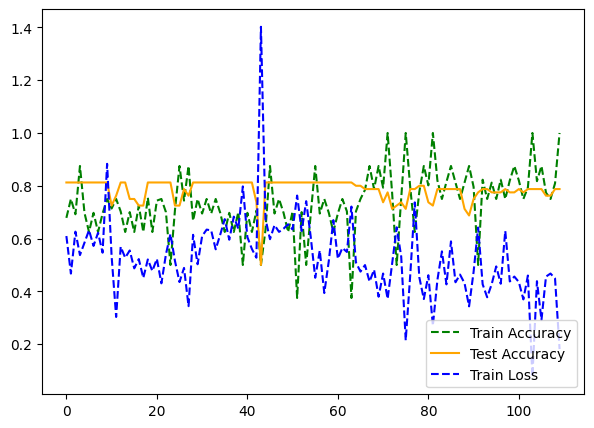

In [15]:
epochs_range = range(epoch)

plt.figure(figsize=(7, 5))
plt.plot(epochs_range, acc, 'g--',label='Train Accuracy')
plt.plot(epochs_range, val_acc,color='orange', label='Test Accuracy')
plt.plot(epochs_range, loss,'b--', label='Train Loss')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=8)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " Presence of DR detected")
  else:
    print(fn + " No DR Detected")

ValueError: File not found: filepath=Final_DR_Classifier.keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=8)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " Presence of DR detected")
  else:
    print(fn + " No DR Detected")

Saving IDRiD_004test.jpg to IDRiD_004test.jpg
1/1 [==============================] - 0s 37ms/step
[0.]
IDRiD_004test.jpg No DR Detected
